In [1]:
%matplotlib inline

# Yellowbrick Text Examples 

This notebook is a sample of the text visualizations that yellowbrick provides

In [2]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import yellowbrick as yb 
import matplotlib.pyplot as plt 

## Load Text Corpus for Example Code

Yellowbrick has provided a text corpus wrangled from the [Baleen RSS Corpus](http://baleen.districtdatalabs.com/) to present the following examples. If you haven't downloaded the data, you can do so by running:

```
$ python download.py
```

In the same directory as the text notebook. Note that this will create a directory called `data` that contains subdirectories with the provided datasets. 

In [3]:
from download import download_all 
from sklearn.datasets.base import Bunch

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "hobbies": os.path.join(FIXTURES, "hobbies")
}


def load_data(name, download=True):
    """
    Loads and wrangles the passed in text corpus by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            
            with open(os.path.join(path, cat, name), 'r') as f:
                data.append(f.read())
        
    
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

## t-SNE: Corpus Visualization 

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. Scikit-Learn implements this decomposition method as the `sklearn.manifold.TSNE` transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot. 

Unfortunately, `TSNE` is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. The `TSNEVisualizer` creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required. 

In [9]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Load the data and create document vectors 
corpus = load_data('hobbies')
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(corpus.data)
labels = corpus.target 

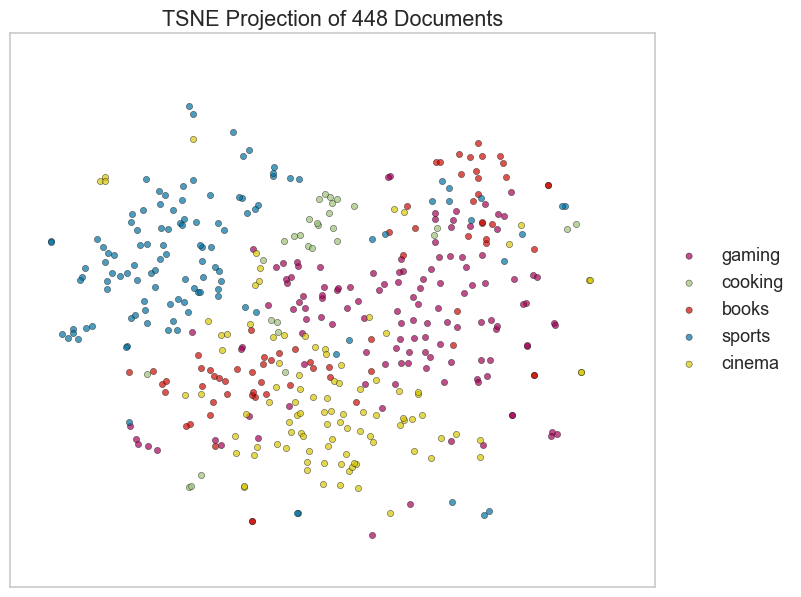

In [11]:
# Create the visualizer and draw the vectors 
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

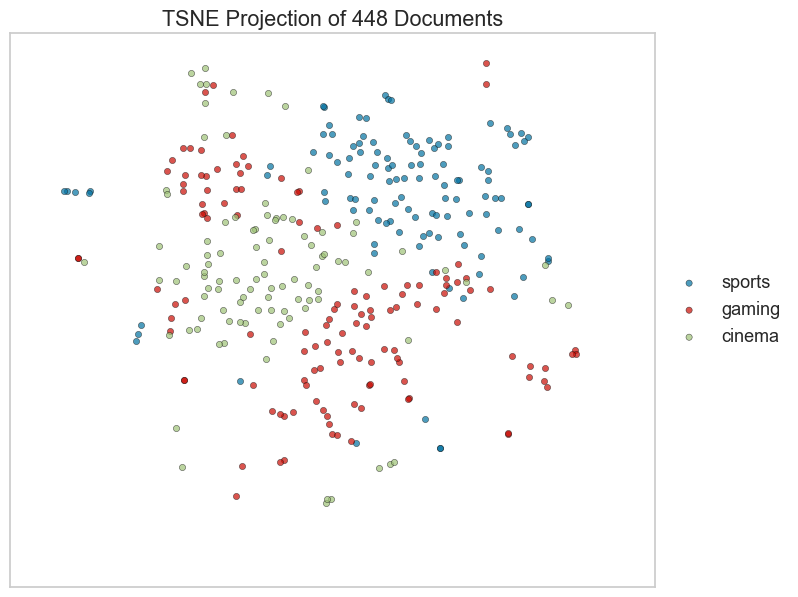

In [12]:
# Only visualize the sports, cinema, and gaming classes 
tsne = TSNEVisualizer(classes=['sports', 'cinema', 'gaming'])
tsne.fit(docs, labels)
tsne.poof()

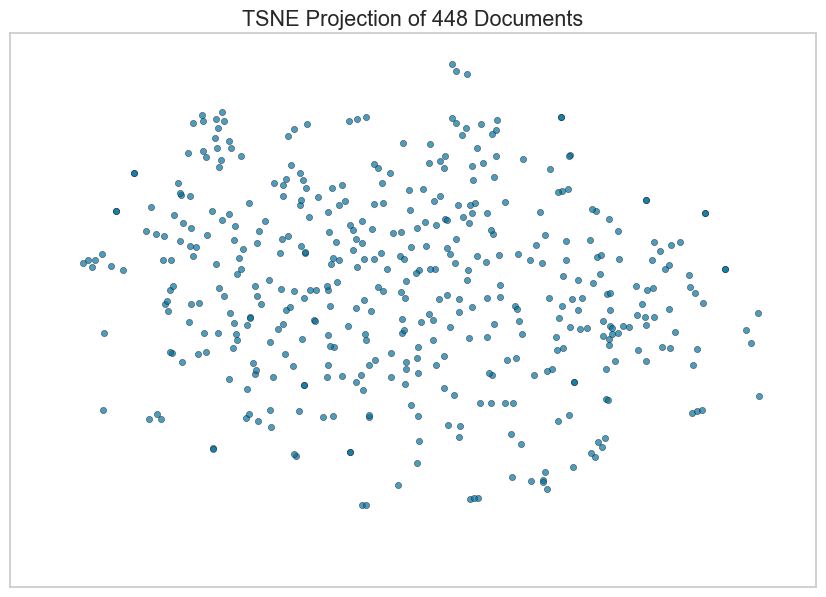

In [13]:
# Don't color points with their classes 
tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

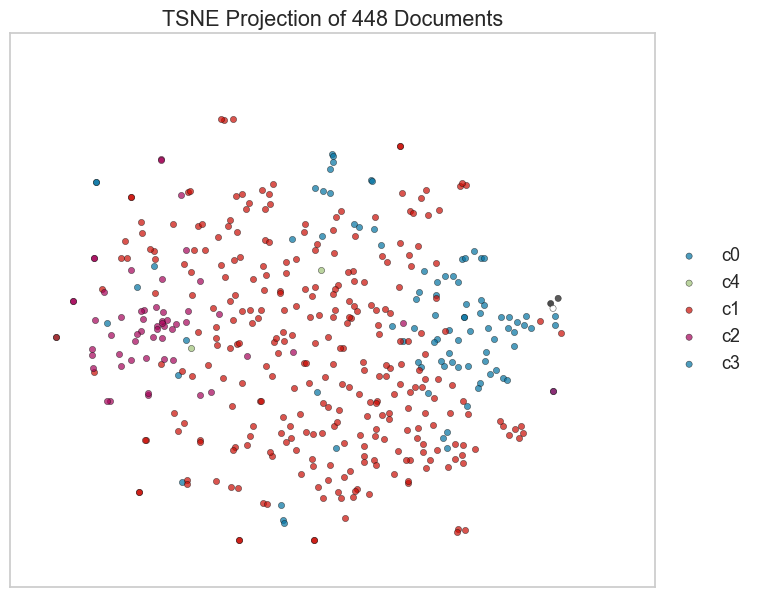

In [19]:
# Apply clustering instead of class names. 
from sklearn.cluster import MiniBatchKMeans 

clusters = MiniBatchKMeans(n_clusters=5)
clusters.fit(docs)

tsne = TSNEVisualizer() 
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()